# Latent Semantic Analysis (LSA)

This notebook is for studying SVD further: will need to project the test data into the same semantic space (see IntroToTextAnalyticsWithR, part 8: "As with TF-IDF, we will need to project new data (e.g., the test data) into the SVD semantic space."

Consulted Prof. Steve Brunton's [YouTube lecture series](https://www.youtube.com/playlist?list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv) and [Data-Driven Science and Engineering book](https://www.amazon.com/Data-Driven-Science-Engineering-Learning-Dynamical/dp/1108422098) - a brief summary of relevant parts can be found [here](./Extra_SteveBrunton_SVD_lecture.pdf).

Using sklearn's **TruncatedSVD** class' ARPACK algorithm (seemed a lot faster than the randomized option in the case). Under the hood, this class just uses `scipy.psarse.linalg`:

[(source)](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/decomposition/_truncated_svd.py#L24)
```
from scipy.sparse.linalg import svds

        if self.algorithm == "arpack":
            U, Sigma, VT = svds(X, k=self.n_components, tol=self.tol)
            # svds doesn't abide by scipy.linalg.svd/randomized_svd
            # conventions, so reverse its outputs.
            Sigma = Sigma[::-1]
            U, VT = svd_flip(U[:, ::-1], VT[::-1])
```    

---

**Toy Example**

In [5]:
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix

X_example = sparse_random(200, 50, density=0.01, format='csr', random_state=42)

In [6]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

U, Sigma, VT = svds(X_example, k=5)
Sigma = Sigma[::-1]
U, VT = svd_flip(U[:, ::-1], VT[::-1])

In [7]:
U.shape, Sigma.shape, VT.shape

((200, 5), (5,), (5, 50))

In [14]:
# save to current dir
import pandas as pd
df = pd.DataFrame(X_example.toarray())
df.to_csv("../data/X_example.csv", index=False)

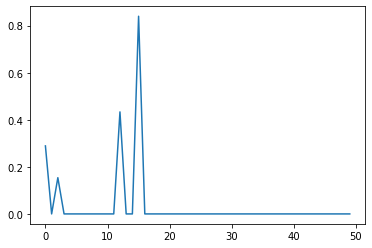

In [13]:
import matplotlib.pyplot as plt 

plt.plot(VT[0])
plt.show()

R code for the same plot:

```
# setup
rm(list=ls())
library(irlba)
wd_ <- "../GitHub/TwitterSentimentAnalysis/data"
if (getwd() != wd_) setwd(wd_)
# read csv
X <- read.csv("X_example.csv")
X <- as.matrix(X)
# svd
svd_ <- irlba(X, nv=5, maxit=10)
# plot
plot(svd_$v[,1], type='l', col='blue', ylab='First Right Singular Vector')
# save plot
dev.copy(png,'../plots/FirstRightSingularVector.png')
dev.off()
```

In [19]:
sigma_inv = 1 / Sigma
doc = X_example[1:2,:].toarray()

In [20]:
sigma_inv.shape

(5,)

In [21]:
U.T.shape

(5, 200)

In [23]:
import numpy as np
first_term = np.dot(sigma_inv, U.T)

In [24]:
np.array([first_term]).T.shape

(200, 1)

In [25]:
doc.shape

(1, 50)

In [26]:
doc_hat = np.matmul(np.array([first_term]).T, doc)

In [27]:
doc_hat.shape

(200, 50)

In [28]:
doc_hat[1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.16717761e-18, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [29]:
VT[1]

array([-4.75284737e-17,  3.43530344e-17,  4.34131568e-17,  9.07556074e-17,
       -2.98926356e-17, -3.14436246e-18,  2.28182027e-17, -3.51942635e-17,
       -7.96049297e-17, -1.03033064e-17, -1.76917179e-16, -2.37183991e-16,
       -2.34192063e-16,  1.75757282e-16,  2.11109649e-01, -3.24362967e-16,
        1.45254682e-16, -4.80416316e-17,  3.88166712e-01,  2.76441640e-17,
       -2.71879645e-18, -1.52319031e-18,  6.74938557e-17, -1.42779339e-16,
       -6.20779526e-16,  5.20037409e-18,  2.26306789e-01, -8.50707805e-17,
       -1.87314724e-17, -2.12918299e-16, -1.24912019e-16, -1.28030046e-16,
       -1.66644215e-16, -2.42245450e-17, -3.80811930e-18,  2.76144937e-17,
       -1.13017678e-17, -1.72226210e-16,  1.26786689e-16,  8.82412951e-17,
        8.68069442e-01,  2.60391365e-16,  9.84947247e-17,  2.20188096e-18,
       -2.16635652e-16, -4.66285530e-17,  1.17237219e-16,  1.10789496e-16,
        1.17584119e-16,  1.51452527e-17])

In [17]:
# As with TF-IDF, we will need to project new data (e.g., the test data)
# into the SVD semantic space. The following code illustrates how to do
# this using a row of the training data that has already been transformed
# by TF-IDF.

#sigma.inverse <- 1 / train.irlba$d
#sigma_inv = 1 / svd_model.singular_values_

#u.transpose <- t(train.irlba$u)


#document <- train.tokens.tfidf[1,]

#document_hat <- sigma_inv * Ut %*% document

# Look at the first 10 components of projected document and the corresponding
# row in our document semantic space (i.e., the V matrix)
#document.hat[1:10]
#train.irlba$v[1, 1:10]


#
# Create new feature data frame using our document semantic space of 300
# features (i.e., the V matrix from our SVD).
#
#train.svd <- data.frame(Label = train$Label, train.irlba$v)
